In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..','UTILS'))
from cosamp_fn import cosamp

np.random.seed(123)
# cosamp function is available at https://github.com/avirmaux/CoSaMP
# copy function from ipynb into cosamp_fn.py and place in UTILS folder

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [4]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [27]:
## Randomly sample signal
p = 128 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

[3163 3951  773 2707 1462 2504 3156 1401 3306 3891 3662 2559 2860 2285
 3722  990 1770 2319 1728 3199  434  907 3268 2052  844 3364 2122 2811
 3112 2291 3115 4062 3089  991   58 2791  336  990 3517  729 3999  246
 3050 1187 3272 2476 3677 1181 1505 1210 3157 3583 3262 1211 3449 1579
  511 3579 3395 1803 1074  666 2705 2407 1173 1623 2733  898  925 2947
 2102 2723 2750 3061  120 1282 1318 3087 2921 2065 3657  653  980  446
 1050 1892  549 3639 3836 3488 3398 3432  803 3071 1465 1952  648  132
 1937 3768 3789 2987  112  684  965 3215  739 3905 3709 2170 3071 1776
  677 2886 3680  582  872 2683 1662 2752  726 2050  147 2384  588 1630
 3747 1572]


In [28]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

s_est = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit

#time.sleep(10)
xrecon = idct(s_est) # reconstruct full signal

/Users/german/opt/anaconda3/envs/snake/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/german/opt/anaconda3/envs/snake/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


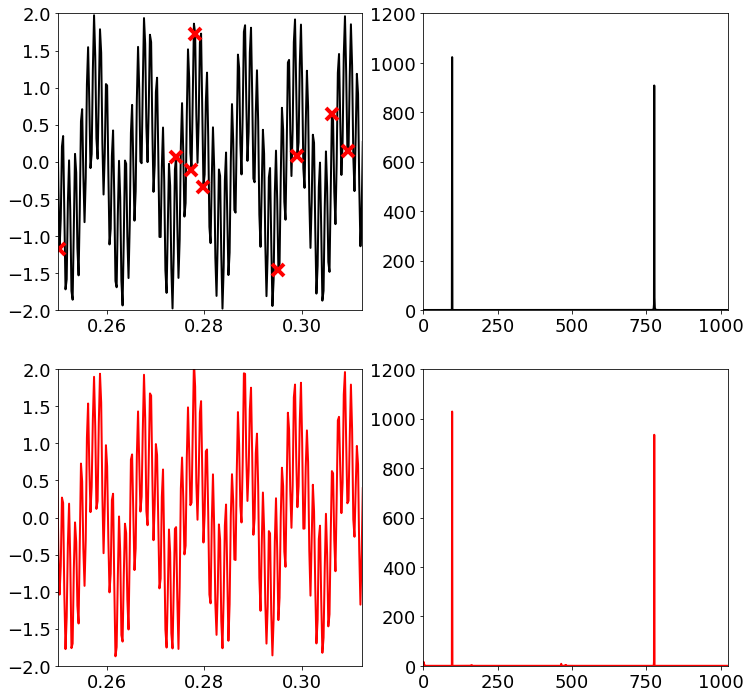

In [13]:
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))
print(L)
print(freq.shape)
print(freq[:L].shape)

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

In [8]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

In [9]:
Theta.shape

(128, 4096)

In [10]:
y.shape

(128,)